In [2]:
import xarray as xr
import numpy as np
import glob
import os

In [180]:
case = 'SIT_f101_BNRH_test'

In [181]:
stages = ['preassim','pre_filter','post_filter','postprocessed','analysis','forecast']

The goal of this notebook is to produce collated timeseries for each stage of the assimilation case that will then be moved to the project directory for long-term storage.

- Outcome: single netcdf files for each of the determined stages
- Inputs: the individual DA cycle netcdf files stored in the scratch directory.

In [ ]:
# We need to assign a time dimension to the data files 
# We should then concatenate the files along the time dimension using nco
# We should then concatenate the files along a new dimension (ensemble_member) using xarray




In [182]:
output_path = '/glade/work/mollyw/Projects/cice-scm-da/data/processed/'+case+'/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

for stage in stages:
    if stage in ['input','preassim','analysis','output']:
        base_path = '/glade/scratch/mollyw/ICEPACK_RUNS/'+case+'/output_files/'
    elif stage in ['pre_filter','post_filter','postprocessed']:
        base_path = '/glade/scratch/mollyw/ICEPACK_RUNS/'+case+'/analyses/'
    elif stage in'forecast':
        base_path = '/glade/scratch/mollyw/ICEPACK_RUNS/'+case+'/forecasts/'
    else:
        print('stage '+stage+' not recognized')
        break
    
    if stage in ['preassim','analysis','pre_filter','postprocessed','post_filter','forecast']:
        # Cycle over ensemble members and concatenate in time
        if 'output_files' in base_path:
            for i in range(1,30):
                os.system('ncecat '+base_path+'????-??-??/'+stage+'_member_00'+f"{i:02d}"+'.nc '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
                os.system('ncrename -d record,time '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
        elif 'analyses' in base_path:
            for i in range(1,31):
                if i == 14:
                    if stage == 'postprocessed':
                        os.system('ncecat '+base_path+'????-??-??/truth_data_00'+f"{i:02d}"+'.nc '+output_path+'truth_data_00'+f"{i:02d}"+'.nc')
                        os.system('ncrename -d record,time '+output_path+'truth_data_00'+f"{i:02d}"+'.nc')
                    else:
                        continue
                else:
                    os.system('ncecat '+base_path+'????-??-??/'+stage+'_restart_00'+f"{i:02d}"+'.nc '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
                    os.system('ncrename -d record,time '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
        elif 'forecast' in base_path:
            for i in range(1,31):
                os.system('ncecat '+base_path+'????-??-??/icepack.h.????-??-??_00'+f"{i:02d}"+'.nc '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
                # take an average over the time dimension
                os.system('ncwa -O -C -a time '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
                # drop the time dimension (which should now have length 1) and rename the record dimension to time
                os.system('ncks -O -C -x -v time '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
                os.system('ncrename -d record,time '+output_path+stage+'_member_00'+f"{i:02d}"+'.nc')
        else:
            print('Assimilation stage not recognized! Exiting.')
            break
        
        # Using python, concatenate all the ensemble member files 
        DS = []
        files = glob.glob(output_path+stage+'_member_00*.nc')
        for file in files:
            ds = xr.open_dataset(file)
            DS.append(ds)
        ens_ds = xr.concat(DS,dim='ensemble_member')
        ens_ds.to_netcdf(output_path+stage+'_ens.nc')

    # if the *_ens.nc file exists, delete the individual member files using os.remove()
    if os.path.exists(output_path+stage+'_ens.nc'):
        for f in glob.glob(output_path+stage+'_member_00*.nc'):
            os.remove(f)

    # Concatenate all the mean and sd files across time if they exist
    if os.path.exists(base_path+'2011-01-02/'+stage+'_mean.nc'):
        os.system('ncecat '+base_path+'????-??-??/'+stage+'_mean.nc '+output_path+stage+'_mean.nc')
        os.system('ncecat '+base_path+'????-??-??/'+stage+'_sd.nc '+output_path+stage+'_sd.nc')
        os.system('ncrename -d record,time '+output_path+stage+'_mean.nc')
        os.system('ncrename -d record,time '+output_path+stage+'_sd.nc')


    # Concatenate all the prior inflation files across time, if they exist
    if os.path.exists(base_path+'2011-01-02/'+stage+'_priorinf_mean.nc'):
        os.system('ncecat '+base_path+'????-??-??/'+stage+'_priorinf_mean.nc '+output_path+stage+'_priorinf_mean.nc')
        os.system('ncecat '+base_path+'????-??-??/'+stage+'_priorinf_sd.nc '+output_path+stage+'_priorinf_sd.nc')
        os.system('ncrename -d record,time '+output_path+stage+'_priorinf_mean.nc')
        os.system('ncrename -d record,time '+output_path+stage+'_priorinf_sd.nc')

    # if the stage is forecast, pre_filter, postprocessed, or post_filter, calculated the mean and sd across the ensemble_member dimension using nco
    if stage in ['forecast','pre_filter','postprocessed','post_filter']:
        os.system('ncwa -a ensemble_member '+output_path+stage+'_ens.nc '+output_path+stage+'_mean.nc')
        os.system('ncbo -O '+output_path+stage+'_ens.nc '+output_path+stage+'_mean.nc '+output_path+stage+'_devs.nc')
        os.system('ncwa -O -y rmssdn -a ensemble_member '+output_path+stage+'_devs.nc '+output_path+stage+'_sd.nc')
        # remove the temporary files
        os.remove(output_path+stage+'_devs.nc')

ncbo: WARNING Input variables have different NCO_MSS_VAL_SNG's:
Variable #1 = FY has NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Variable #2 = FY has NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Variable #3 = output = FY will have NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Will translate values of var2 equaling mss_val2 to mss_val1 before evaluating arithmetic operation to compute var3
ncbo: WARNING Input variables have different NCO_MSS_VAL_SNG's:
Variable #1 = Tsfcn has NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Variable #2 = Tsfcn has NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Variable #3 = output = Tsfcn will have NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Will translate values of var2 equaling mss_val2 to mss_val1 before evaluating arithmetic operation to compute var3
ncbo: WARNING Input variables have different NCO_MSS_VAL_SNG's:
Variable #1 = aeroiceint001 has NCO_MSS_VAL_SNG type = NC_DOUBLE, value = nan
Variable #2 = aeroiceint001 has NCO_MSS_VAL_SNG type = NC_D

In [177]:
file = '/glade/work/mollyw/Projects/cice-scm-da/data/processed/AGR_f101_BNRH_opt2/preassim_ens.nc'
ds1 = xr.open_dataset(file)
aice1 = ds1.vicen.sum(dim='ncat').isel({'ni':2})

file = '/glade/work/mollyw/Projects/cice-scm-da/data/processed/AGR_f101_BNRH_opt2/forecast_ens.nc'
ds2 = xr.open_dataset(file)
aice2 = ds2.vicen.sum(dim='ncat').isel({'ni':2})

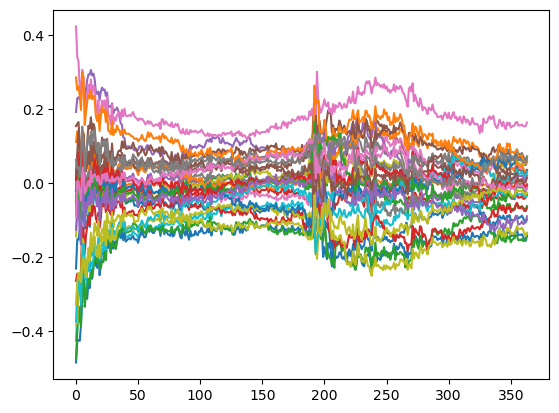

In [179]:
plt.plot(aice1.transpose() - aice2.isel(ensemble_member = slice(0,29)).transpose())

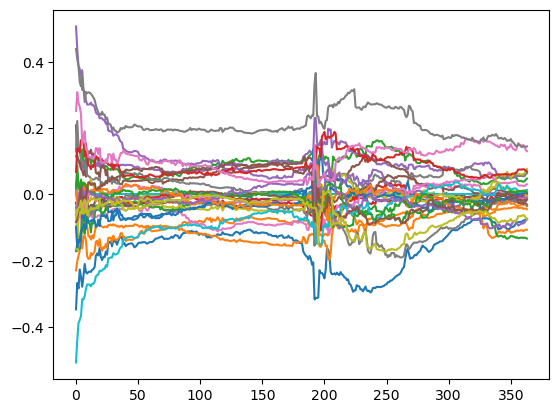

In [176]:
plt.plot(aice1.transpose() - aice2.transpose())
# plt.plot(aice2)

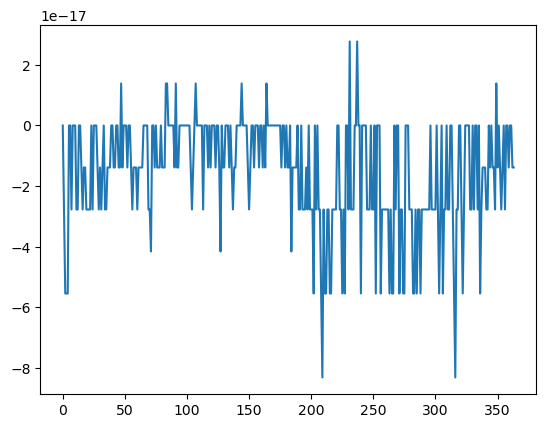

In [154]:
plt.plot(aice1-aice2)
# plt.ylim([-0.0001,0.0001])

In [14]:
import matplotlib.pyplot as plt

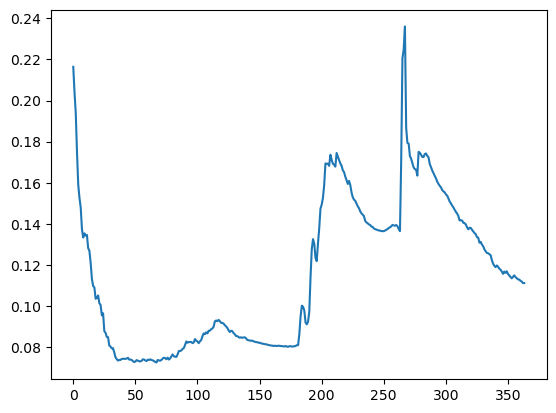

In [32]:
plt.plot(aice1)
# plt.plot(aice2.transpose())

In [ ]:
# Check for redundant stages

# Contenders
#  - input and pre_filter
#       - these means and standard devs are the same to round-off error (can't tell about individual ensemble members)
#       - input and pre_filter should be the same (the icepack restarts are the initial conditions for the experiment; the round-off error differences
#         are probably due to the fact that the input file is precalculated by DART and we manually calculate mean and sd for the pre_filter file)
#  - input and preassim
#       - these should be different (the inflation has an effect)
#  - pre_filter and post_filter
#      - these are different (the filter has an effect)
#  - postprocessed and post_filter
#      - these are different (postprocessing has an effect)
#  - postprocessed and analysis
#      - post_filter and analysis are the same to round-off error wrt to mean, sds, but different wrt to individual ensemble members 
#      - (what happens here?)
#  - analysis and output 
#     - these are exactly the same (don't do the output stage anymore) (nothing happens between analysis and finishing the assimilation)
#  - FORECAST is the history files after Icepack and run a forecast!! IT IS NOT THE DART FORECAST STAGE 
#     - this is run AFTER the assimilation is finished, and is the forecast for the next assimilation cycle
